### Part 2: THE CLASSIFIER
We are about to classify real and fake audio data as follows:

1) Real audio data VS. Cloned audio data.

2) Real audio data VS. Cloned audio data with removing the noise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd '/content/drive/MyDrive/Kaggle'

/content/drive/MyDrive/Kaggle


In [ ]:
#! kaggle datasets download mozillaorg/common-voice

In [ ]:
#!unzip /content/drive/MyDrive/Kaggle/common-voice.zip

## CommonVoice Dataset:


Common Voice is part of Mozilla's initiative to help teach machines how real people speak. Common Voice is a corpus of speech data read by users on the Common Voice website (https://commonvoice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems.




In [ ]:
import shutil
import librosa 
import os
import random
import pandas as pd
import numpy as np


In [ ]:
files_list = []

for root, dirs, files in os.walk("/content/cv-other-test"):
  for file in files:
    if file.endswith(".mp3"):
      files_list.append(os.path.join(root, file))

# print the files list
filesToCopy = random.sample(files_list, len(files_list))  
destPath ="/content/real_audio"

# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

### 1) Compare Real audio data with Cloned audio data:

### Fake Audio

In [ ]:
fake_files_list =os.listdir("/content/drive/MyDrive/Kaggle/LongVersionAudio")
# Read them into pandas
fake_df = pd.DataFrame(fake_files_list)
fake_df=  fake_df.rename(columns = {0:"file"})
fake_df["real"] = 0
fake_df.file  =[f"/content/drive/MyDrive/Kaggle/LongVersionAudio/{i}" for i in fake_df.file]
fake_df.head()

,file,real
0,/content/drive/MyDrive/Kaggle/LongVersionAudio...,0
1,/content/drive/MyDrive/Kaggle/LongVersionAudio...,0
2,/content/drive/MyDrive/Kaggle/LongVersionAudio...,0
3,/content/drive/MyDrive/Kaggle/LongVersionAudio...,0
4,/content/drive/MyDrive/Kaggle/LongVersionAudio...,0


### Real audio

In [ ]:
#list the files
real_file_list = os.listdir("/content/drive/MyDrive/Kaggle/cv-other-test/cv-other-test") 
#read them into pandas
real_df = pd.DataFrame(real_file_list)
# Renaming the column name to file
real_df = real_df.rename(columns={0:'file'})
real_df['real'] = 1
real_df.file = [f"/content/drive/MyDrive/Kaggle/cv-other-test/cv-other-test/{i}" for i in real_df.file]
real_df.head(2)

,file,real
0,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
1,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1


In [ ]:
real_df.shape, fake_df.shape

((2961, 2), (336, 2))

In [ ]:
df = pd.concat([real_df, fake_df], axis=0)
df.head()

,file,real
0,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
1,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
2,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
3,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
4,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

### Splitting the datasets into train, test, Validation

In [ ]:
from sklearn.model_selection import train_test_split
X = df[["file"]]
y  =df.real
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val  =train_test_split(X_train,y_train, test_size=0.1, random_state=42, shuffle=True)



In [ ]:
print(f"X_train length is : {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is : {len(X_test)}, y_train length is: {len(y_test)}")
print(f"X_val length is : {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is : 2670, y_train length is: 2670
X_test length is : 330, y_train length is: 330
X_Val length is : 297, y_val length is: 297


### Extracting features

In [ ]:
def extract_features(files):
  """
  return mfccs, chroma, mel, contrast and tonnetz for each audio file
  """
  df = {'mfccs' : [], 'chroma' : [], 'mel' : [], 'contrast' : [], 'tonnetz' : []}
  for file_name in files:
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    df['mfccs'].append(mfccs)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    df['chroma'].append(chroma)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    df['mel'].append(mel)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    df['contrast'].append(contrast)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    df['tonnetz'].append(tonnetz)
  return df

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
val_features = extract_features(X_val.file)
train_features =extract_features(X_train.file)
test_features =extract_features(X_test.file)

**Scaling all of the features and concatenate them into an array for each audio file**

In [ ]:
from librosa.feature.spectral import tonnetz
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()


def concat_features(features):
  features_list = []
  for i in range(0, len(features["mfccs"])):
    features_list.append(np.concatenate((
        scaler.fit_transform((features["mfccs"][i]).reshape(-1,1)),
        scaler.fit_transform((features["chroma"][i]).reshape(-1,1)),
        scaler.fit_transform((features["mel"][i]).reshape(-1,1)),
        scaler.fit_transform((features["contrast"][i]).reshape(-1,1)),
        scaler.fit_transform((features["tonnetz"][i]).reshape(-1,1))), axis=0))
  return np.array(features_list).reshape(len(features["mfccs"]), 193)

In [ ]:
X_val_data   = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data  = concat_features(test_features)

In [ ]:
y_train =np.array(y_train)
y_test  =np.array(y_test)
y_val   =np.array(y_val)

### Creating the model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 1) create the model
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=50, input_shape=(193,), activation='relu'),
                             tf.keras.layers.Dense(units=50, activation='relu'),
                            #  tf.keras.layers.Dense(units=50, activation='relu'), 
                             tf.keras.layers.Dense(units=1, activation='sigmoid')])
# 2) compile the model
model_1.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(), optimizer='adam')
# 3) fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
hist_1 = model_1.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=2000, callbacks=[early_stop])

Epoch 1/2000
84/84 [==============================] - 2s 7ms/step - loss: 0.2716 - auc: 0.8290 - val_loss: 0.1363 - val_auc: 0.9827
Epoch 2/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.1156 - auc: 0.9788 - val_loss: 0.0848 - val_auc: 0.9920
Epoch 3/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.0750 - auc: 0.9900 - val_loss: 0.0647 - val_auc: 0.9942
Epoch 4/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.0532 - auc: 0.9957 - val_loss: 0.0604 - val_auc: 0.9956
Epoch 5/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.0414 - auc: 0.9975 - val_loss: 0.0509 - val_auc: 0.9965
Epoch 6/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.0299 - auc: 0.9989 - val_loss: 0.0544 - val_auc: 0.9965
Epoch 7/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.0229 - auc: 0.9994 - val_loss: 0.0453 - val_auc: 0.9975
Epoch 8/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

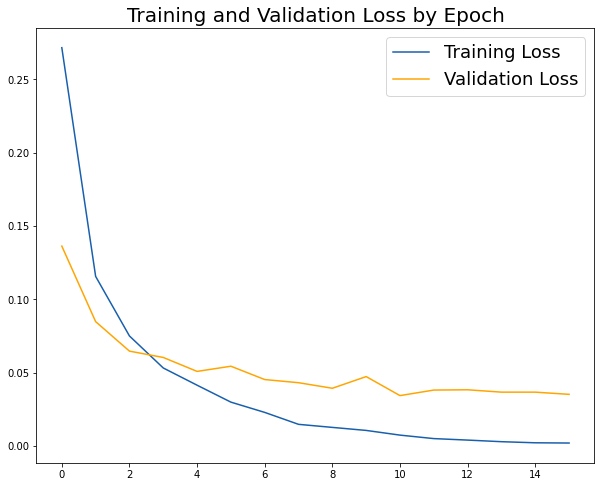

In [ ]:
plt.figure(figsize=(10, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_1.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_1.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

11/11 [==============================] - 0s 3ms/step - loss: 0.0368 - auc: 0.9984
Test evaluation [0.03676757961511612, 0.9984108805656433]
11/11 [==============================] - 0s 2ms/step


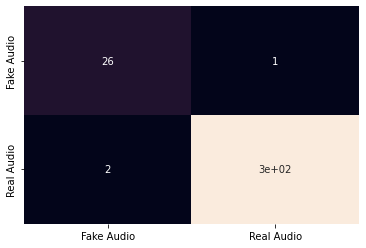

In [ ]:
print("Test evaluation", model_1.evaluate(X_test_data, y_test))
cm= confusion_matrix(y_test, y_pred=tf.round(model_1.predict(X_test_data)))
ax =sns.heatmap(cm, annot=True, cbar=False)

# Ticker labels -list must be in alphabetical order
ax.xaxis.set_ticklabels(["Fake Audio", "Real Audio"])
ax.yaxis.set_ticklabels(["Fake Audio", "Real Audio"])

plt.show();

### 2) Compare real audio data with Cloned audio data after removing the noise:

In [ ]:
pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.io import wavfile
import noisereduce as nr

In [ ]:
for file in os.listdir('/content/drive/MyDrive/Kaggle/LongVersionAudio'):
  # load data
  rate, data = wavfile.read(f'/content/drive/MyDrive/Kaggle/LongVersionAudio/{file}')
  # perform noise reduction
  reduced_noise = nr.reduce_noise(y=data, sr=rate)
  wavfile.write(f"/content/drive/MyDrive/Kaggle/LongAudioVersionWithoutNoise/{file}", rate, reduced_noise)

In [ ]:
#list the files
fake_file_list_without_noise = os.listdir('/content/drive/MyDrive/Kaggle/LongAudioVersionWithoutNoise') 
#read them into pandas
fake_df_without_noise = pd.DataFrame(fake_file_list_without_noise)
# Renaming the column name to file
fake_df_without_noise = fake_df_without_noise.rename(columns={0:'file'})
fake_df_without_noise['real'] = 0
fake_df_without_noise.file = [f"/content/drive/MyDrive/Kaggle/LongAudioVersionWithoutNoise/{i}" for i in fake_df_without_noise.file]
fake_df_without_noise.head(2)

,file,real
0,/content/drive/MyDrive/Kaggle/LongAudioVersion...,0
1,/content/drive/MyDrive/Kaggle/LongAudioVersion...,0


In [ ]:
df_without_noise = pd.concat([real_df, fake_df_without_noise], axis=0)
df_without_noise = df_without_noise.sample(frac=1).reset_index(drop=True)
df_without_noise.head(2)

,file,real
0,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1
1,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,1


In [ ]:
X = df_without_noise[['file']]
y = df_without_noise.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 2670, y_train length is: 2670
X_test length is: 330, y_test length is: 330
X_val length is: 297, y_val length is: 297


In [ ]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [ ]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [ ]:
from IPython.display import Audio

tf.random.set_seed(42)

model_2 =tf.keras.Sequential([
                              tf.keras.layers.Dense(units=193, input_shape=(193,),activation="relu"),
                              tf.keras.layers.Dense(units=50, activation="relu"),
                              tf.keras.layers.Dense(units=1, activation="sigmoid")
])


model_2.compile(loss="binary_crossentropy",
                metrics=tf.keras.metrics.AUC(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001))


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
hist_3 = model_2.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
84/84 [==============================] - 1s 7ms/step - loss: 0.9785 - auc_1: 0.8436 - val_loss: 0.9671 - val_auc_1: 0.8393
Epoch 2/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.9447 - auc_1: 0.8465 - val_loss: 0.9340 - val_auc_1: 0.8432
Epoch 3/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.9123 - auc_1: 0.8476 - val_loss: 0.9020 - val_auc_1: 0.8451
Epoch 4/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.8812 - auc_1: 0.8481 - val_loss: 0.8717 - val_auc_1: 0.8477
Epoch 5/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.8514 - auc_1: 0.8518 - val_loss: 0.8423 - val_auc_1: 0.8508
Epoch 6/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.8227 - auc_1: 0.8524 - val_loss: 0.8141 - val_auc_1: 0.8538
Epoch 7/1000
84/84 [==============================] - 0s 4ms/step - loss: 0.7952 - auc_1: 0.8532 - val_loss: 0.7869 - val_auc_1: 0.8580
Epoch 8/1000
84/84 [============================

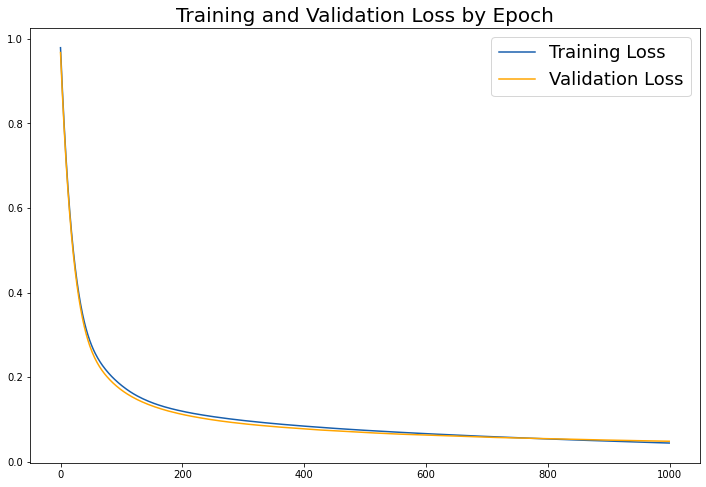

In [ ]:
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_3.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_3.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

11/11 [==============================] - 0s 3ms/step - loss: 0.0473 - auc_1: 0.9987
test evaluation [0.04731465503573418, 0.9987082481384277]
11/11 [==============================] - 0s 2ms/step


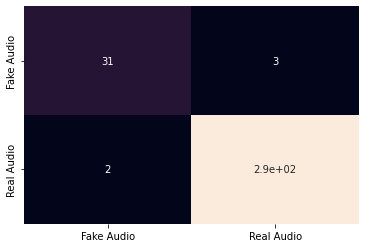

In [ ]:
print('test evaluation', model_2.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=tf.round(model_2.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
predictions_ = X_test.reset_index(drop=True)
predictions_['y_true'] = y_test
pred = np.round(model_2.predict(X_test_data))
predictions_['y_pred'] = pred
predictions_[predictions_.y_true != predictions_.y_pred]

11/11 [==============================] - 0s 3ms/step


,file,y_true,y_pred
1,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
2,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
3,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
4,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
5,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
...,...,...,...
325,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,0.0,1.0
326,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0
327,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,0.0
328,/content/drive/MyDrive/Kaggle/cv-other-test/cv...,NaN,1.0


In [ ]:
Audio(predictions_.file[2], autoplay=True)

In [ ]:
Audio(predictions_.file[16], autoplay=True)